In [ ]:
import sqlite3
import csv
import os
import pandas as pd

# Set the database path to the root of the project
DB_PATH = "Assignment_MIMIC_SQL/database.db"

def create_or_update_database():
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    try:
        # Directory containing CSV files
        data_dir = "Assignment_MIMIC_SQL/data/mimic_data"
        
        # List all CSV files in the directory
        csv_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.csv')]

        for file in csv_files:
            # Read CSV file in chunks using pandas
            table_name = os.path.splitext(os.path.basename(file))[0]
            chunk_size = 10000  # Adjust the chunk size as needed

            for chunk in pd.read_csv(file, chunksize=chunk_size):
                if chunk.empty:
                    continue

                # Create table if doesn't exist and insert data
                chunk.to_sql(table_name, conn, if_exists='append', index=False)

        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        conn.close()

def clear_database():
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    try:
        # Get the list of all tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        # Drop each table
        for table in tables:
            cursor.execute(f"DROP TABLE IF EXISTS {table[0]}")
            print(f"Dropped table {table[0]}")

        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        conn.close()


if __name__ == "__main__":
    create_or_update_database()

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('../Assignment_MIMIC_SQL/database.db')

# Fetch ICU stays and mortality labels
query_icu = """
SELECT icu.SUBJECT_ID, icu.HADM_ID, icu.ICUSTAY_ID, 
       adm.ADMITTIME, adm.DEATHTIME, 
       CASE 
           WHEN adm.DEATHTIME IS NOT NULL AND adm.DEATHTIME <= icu.OUTTIME THEN 1 
           ELSE 0 
       END AS MORTALITY
FROM ICUSTAYS icu
JOIN ADMISSIONS adm ON icu.HADM_ID = adm.HADM_ID;
"""
icu_stays = pd.read_sql(query_icu, conn)

# Fetch vital signs
query_vitals = """
SELECT ce.SUBJECT_ID, ce.HADM_ID, ce.ICUSTAY_ID, 
       ce.ITEMID, ce.CHARTTIME, ce.VALUE
FROM CHARTEVENTS ce
WHERE ce.ITEMID IN (211, 220045, 220179, 220180, 220210, 220277, 223761)
AND ce.VALUE IS NOT NULL;
"""
vitals = pd.read_sql(query_vitals, conn)

# Fetch lab test results
query_labs = """
SELECT le.SUBJECT_ID, le.HADM_ID, 
       le.ITEMID, le.CHARTTIME, le.VALUE
FROM LABEVENTS le
WHERE le.ITEMID IN (50809, 50912, 51300)
AND le.VALUE IS NOT NULL;
"""
labs = pd.read_sql(query_labs, conn)

# Close the connection
conn.close()

# Display sample data
print("ICU Stays:\n", icu_stays.head())
print("Vitals:\n", vitals.head())
print("Labs:\n", labs.head())



ICU Stays:
    SUBJECT_ID  HADM_ID  ICUSTAY_ID            ADMITTIME            DEATHTIME  \
0         268   110404      280836  2198-02-11 13:40:00  2198-02-18 03:55:00   
1         269   106296      206613  2170-11-05 11:04:00                 None   
2         270   188028      220345  2128-06-23 18:26:00                 None   
3         271   173727      249196  2120-08-07 18:56:00                 None   
4         272   164716      210407  2186-12-25 21:06:00                 None   

   MORTALITY  
0          1  
1          0  
2          0  
3          0  
4          0  
Vitals:
    SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID            CHARTTIME  VALUE
0          36   165660    241249.0  220045  2134-05-12 13:00:00   86.0
1          36   165660    241249.0  220179  2134-05-12 13:00:00  137.0
2          36   165660    241249.0  220180  2134-05-12 13:00:00   72.0
3          36   165660    241249.0  220210  2134-05-12 13:00:00   21.0
4          36   165660    241249.0  220277  2134-05-1

In [ ]:
# 1. Convert Timestamps to datetime Format
# This ensures we can sort and resample data correctly.
icu_stays["ADMITTIME"] = pd.to_datetime(icu_stays["ADMITTIME"])
icu_stays["DEATHTIME"] = pd.to_datetime(icu_stays["DEATHTIME"])

vitals["CHARTTIME"] = pd.to_datetime(vitals["CHARTTIME"])
labs["CHARTTIME"] = pd.to_datetime(labs["CHARTTIME"])


In [ ]:
# 2. Map ITEMID to Readable Feature Names
# Since ITEMID numbers aren't human-readable, we map them to their respective vitals/labs.
vital_signs_mapping = {
    211: "HEART_RATE",
    220045: "MEAN_BP",
    220179: "SYSTOLIC_BP",
    220180: "DIASTOLIC_BP",
    220210: "RESP_RATE",
    220277: "SPO2",
    223761: "TEMPERATURE"
}

lab_tests_mapping = {
    50809: "GLUCOSE",
    50912: "CREATININE",
    51300: "WBC_COUNT"
}

# Replace ITEMID with actual feature names
vitals["ITEMID"] = vitals["ITEMID"].map(vital_signs_mapping)
labs["ITEMID"] = labs["ITEMID"].map(lab_tests_mapping)


In [6]:
# Pivot the tables so each ITEMID becomes a column
labs["VALUE"] = pd.to_numeric(labs["VALUE"], errors="coerce")
vitals["VALUE"] = pd.to_numeric(vitals["VALUE"], errors="coerce")



In [ ]:
# Pivot the tables so each ITEMID becomes a column
vitals_pivot = vitals.pivot_table(index=["SUBJECT_ID", "HADM_ID", "CHARTTIME"], 
                                  columns="ITEMID", values="VALUE").reset_index()

# Pivot the tables so each ITEMID becomes a column
labs_pivot = labs.pivot_table(index=["SUBJECT_ID", "HADM_ID", "CHARTTIME"], 
                              columns="ITEMID", values="VALUE").reset_index()


In [10]:
# Merge vitals and labs
merged_data = vitals_pivot.merge(labs_pivot, on=["SUBJECT_ID", "HADM_ID", "CHARTTIME"], how="outer")

# Merge with ICU stay data (Mortality Label)
final_data = merged_data.merge(icu_stays[["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "MORTALITY"]], 
                               on=["SUBJECT_ID", "HADM_ID"], how="inner")

# Sort by time
final_data = final_data.sort_values(by=["SUBJECT_ID", "CHARTTIME"])


In [11]:
# Fill missing values forward and backward for vitals
final_data.fillna(method="ffill", inplace=True)
final_data.fillna(method="bfill", inplace=True)

# Impute remaining missing values with median
final_data.fillna(final_data.median(), inplace=True)


In [12]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns (excluding SUBJECT_ID, HADM_ID, CHARTTIME)
feature_cols = [col for col in final_data.columns if col not in ["SUBJECT_ID", "HADM_ID", "CHARTTIME", "ICUSTAY_ID", "MORTALITY"]]

# Scale features
scaler = StandardScaler()
final_data[feature_cols] = scaler.fit_transform(final_data[feature_cols])


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert Data to LSTM/GRU Format
window_size = 24  

def create_sequences(df, window_size):
    sequences, labels = [], []
    for patient_id in df["ICUSTAY_ID"].unique():
        patient_data = df[df["ICUSTAY_ID"] == patient_id].sort_values("CHARTTIME")
        for i in range(len(patient_data) - window_size):
            seq = patient_data.iloc[i : i + window_size][feature_cols].values
            label = patient_data.iloc[i + window_size]["MORTALITY"]  # Binary outcome
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# Convert to sequences
X, y = create_sequences(final_data, window_size)

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the datasets as .npy files
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print("Final Shape:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Dataset saved successfully!")

Final Shape: (7413697, 24, 10) (1853425, 24, 10) (7413697,) (1853425,)
Dataset saved successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

# Example usage (assuming X_train is preprocessed and shaped correctly)
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.summary()

NameError: name 'X_train' is not defined

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load your preprocessed dataset
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_test.npy") 
y_val = np.load("y_test.npy")


# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

# Save final model
model.save("final_lstm_model.h5")


Epoch 1/2


2025-03-15 15:17:16.975829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 15:17:17.238728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 15:17:17.307381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


     1/231679 [..............................] - ETA: 92:06:33 - loss: 0.7022 - accuracy: 0.5312

2025-03-15 15:17:17.443259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 15:17:17.530265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


231679/231679 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.8991

2025-03-15 15:58:38.158862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 15:58:38.273451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 15:58:38.312400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


231679/231679 [==============================] - 2717s 12ms/step - loss: 0.2806 - accuracy: 0.8991 - val_loss: 0.2508 - val_accuracy: 0.9062
Epoch 2/2
    11/231679 [..............................] - ETA: 45:46 - loss: 0.2434 - accuracy: 0.9176 

/opt/homebrew/Caskroom/miniconda/base/envs/ai_health/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231679/231679 [==============================] - 2755s 12ms/step - loss: 0.2348 - accuracy: 0.9106 - val_loss: 0.2217 - val_accuracy: 0.9146


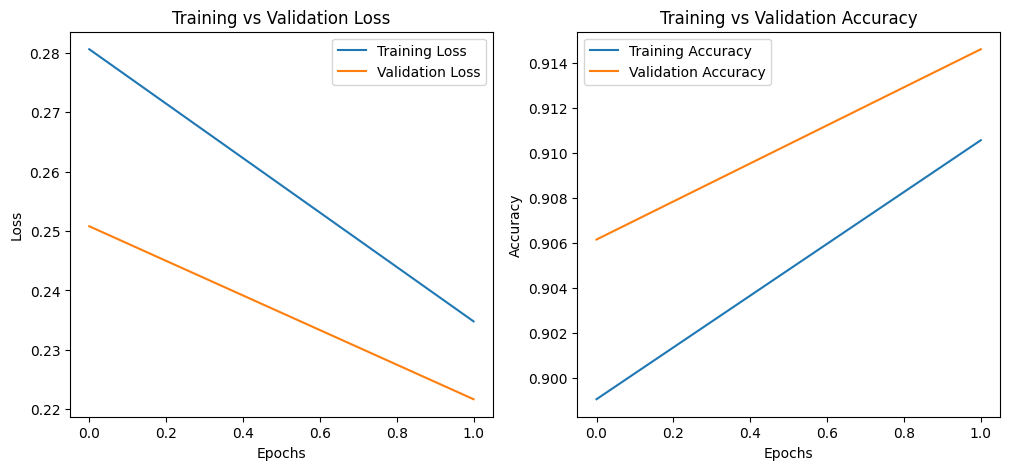

In [7]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.show()


In [8]:
import numpy as np
import tensorflow as tf

# Load test data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the best saved model
model = tf.keras.models.load_model("best_lstm_model.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2025-03-15 16:53:34.410276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 16:53:34.518800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 16:53:34.571520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57920/57920 [==============================] - 269s 5ms/step - loss: 0.2217 - accuracy: 0.9146
Test Loss: 0.2217
Test Accuracy: 0.9146


In [9]:
import numpy as np
import tensorflow as tf

# Load test data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the best saved model
model = tf.keras.models.load_model("final_lstm_model.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

    1/57920 [..............................] - ETA: 6:13:13 - loss: 0.2704 - accuracy: 0.9062

2025-03-15 16:58:08.796805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 16:58:08.889784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-15 16:58:08.928606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57920/57920 [==============================] - 270s 5ms/step - loss: 0.2217 - accuracy: 0.9146
Test Loss: 0.2217
Test Accuracy: 0.9146
